Permisi reviewer, perkenalkan saya Naufal Hafish Junianto, saya melakukan text classification dengan dataset AG News Classification dari website Kaggle, dataset tersebut memiliki 120000 rows dan 4 kelas.


In [ ]:
#  Mengimport library yang dibutuhkan

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split as tts
from keras.models import Sequential as sq
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Dense, LSTM, Bidirectional, Dropout, GlobalMaxPooling1D
from keras.callbacks import Callback, EarlyStopping
from keras.regularizers import l2, l1

import matplotlib.pyplot as plt

In [ ]:
#  Membaca file dataset

data = pd.read_csv('ag news classification.csv')
data

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


In [ ]:
#  Di dataset saya tidak ada bagian yang kosong

data.isna().sum()

Class Index    0
Title          0
Description    0
dtype: int64

In [ ]:
#  Kelas dataset saya memiliki sampel yang seimbang

data['Class Index'].value_counts()

3    30000
4    30000
2    30000
1    30000
Name: Class Index, dtype: int64

In [ ]:
#  Saya mengganti nomor sesuai dengan topik, agar kedepannya lebih jelas

data.loc[:, 'Class Index'] = data['Class Index'].map({
    1 : 'World',
    2 : 'Sports',
    3 : 'Business',
    4 : 'Sci-Tech'
})
data

,Class Index,Title,Description
0,Business,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,Business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,Business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,Business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,Business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
119995,World,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,Sports,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,Sports,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,Sports,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


In [ ]:
#  Saya menggunakan one-hot-encoding karena dataset saya memiliki 4 kelas

category = pd.get_dummies(data['Class Index'])
new_data = pd.concat([data, category], axis=1)
new_data =  new_data.drop(columns=['Class Index'])
new_data

,Title,Description,Business,Sci-Tech,Sports,World
0,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",1,0,0,0
1,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,1,0,0,0
2,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,1,0,0,0
3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,1,0,0,0
4,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",1,0,0,0
...,...,...,...,...,...,...
119995,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...,0,0,0,1
119996,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...,0,0,1,0
119997,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...,0,0,1,0
119998,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...,0,0,1,0


In [ ]:
target = new_data['Title'] + " " + new_data['Description']  #  Saya menggabungkan kolom Title dan kolom Description karena sama-sama penting untuk dijadikan target
label = new_data[['Business', 'Sci-Tech', 'Sports', 'World']].values

In [ ]:
target.shape, label.shape

((120000,), (120000, 4))

In [ ]:
panjang = target.map(lambda text: len(text.split())).max()  #  Menambahkan fitur untuk mencari panjang maksimal dari semua rows

print(panjang)

177


In [ ]:
target_train, target_test, label_train, label_test = tts(target, label, test_size=0.2)

In [ ]:
target_train.shape, target_test.shape

((96000,), (24000,))

In [ ]:
label_train.shape, label_test.shape

((96000, 4), (24000, 4))

In [ ]:
dim = 10000
token = Tokenizer(num_words=dim, oov_token='<unk>')
token.fit_on_texts(target_train.values)

In [ ]:
seque_train = token.texts_to_sequences(target_train)
seque_test = token.texts_to_sequences(target_test)

pad_train = pad_sequences(seque_train, maxlen = panjang)
pad_test = pad_sequences(seque_test, maxlen = panjang)

In [ ]:
#  Membuat class Callback, saya menggunakan threshold 91% ketika akurasi latih dan akurasi validasi mencapai angka di atas 91% maka training akan berhenti

class Mycallback(Callback):

     def on_epoch_end(self, epochs, logs=None):
       acc, val_acc = logs.get('accuracy'), logs.get('val_accuracy')
       if acc > 0.91 and val_acc > 0.91:
         self.model.stop_training = True


earlystop = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 4, min_delta = 0.001, verbose = 1)

callback = [Mycallback(), earlystop]

In [ ]:
model = sq()
model.add(Embedding(dim, 32, input_length=panjang))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax'))

In [ ]:
model.compile(optimizer=Adam(learning_rate = 0.0005),
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [ ]:
hist = model.fit(pad_train,
          label_train,
          batch_size = 32,
          callbacks = callback,
          validation_data = (pad_test, label_test),
          epochs = 30)

Epoch 1/30
3000/3000 [==============================] - 99s 31ms/step - loss: 0.4233 - accuracy: 0.8444 - val_loss: 0.2856 - val_accuracy: 0.9050
Epoch 2/30
3000/3000 [==============================] - 70s 23ms/step - loss: 0.2397 - accuracy: 0.9210 - val_loss: 0.2558 - val_accuracy: 0.9139


In [ ]:
model.evaluate(pad_test, label_test)

750/750 [==============================] - 7s 10ms/step - loss: 0.2558 - accuracy: 0.9139


[0.2557990252971649, 0.9138749837875366]

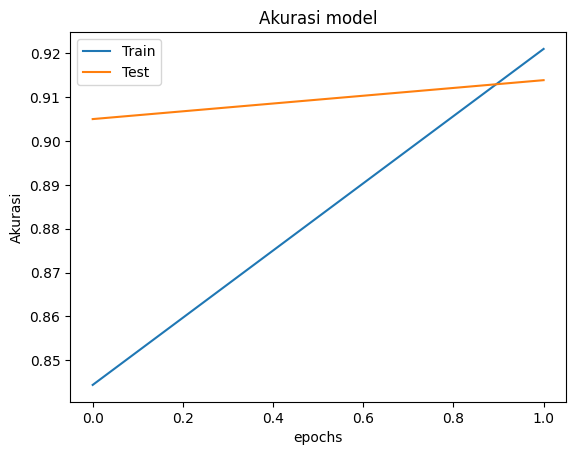

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Akurasi model')
plt.ylabel('Akurasi')
plt.xlabel('epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

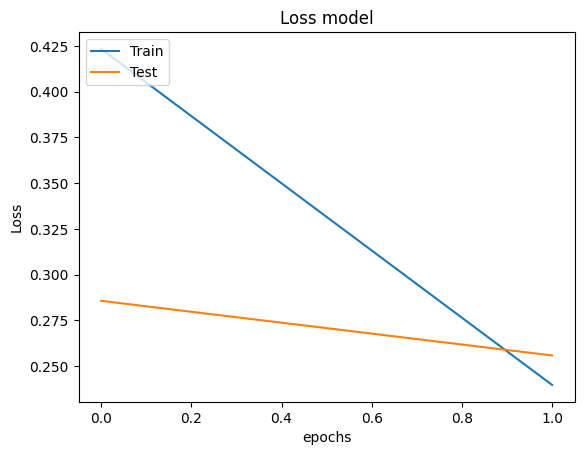

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss model')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()